<a href="https://colab.research.google.com/github/hikaru122700/kaggle-private/blob/SMBC/092.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
!pip install pygeohash
!pip install catboost
!pip install lightgbm
!pip install xgboost
!pip install optuna

In [44]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
import math

# import pygeohash as pgh

from concurrent.futures import ThreadPoolExecutor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import optuna
import matplotlib.pyplot as plt


import os
from catboost import CatBoostClassifier


In [45]:
path  = "/content/drive/My Drive/signate/SMBC Group GREEN×DATA Challenge 2024/"
# 予測モデルを訓練するためのデータセット
train_df = pd.read_csv(path+'train_all_df.csv')

train_df.drop("GHG_Direct_Emissions_14_in_metric_tons", axis=1, inplace=True)
# 予測モデルに推論（予測)させるデータセット
test_df = pd.read_csv(path+'test_all_df.csv')

In [46]:
# すべての列を表示するように設定
pd.set_option('display.max_columns', None)
train_df.columns

Index(['TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
       'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs',
       'PrimaryNAICS', 'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons', 'Latitude', 'Longitude',
       'TRI_Air_Emissions_YoY_Change_11', 'TRI_Air_Emissions_YoY_Change_12',
       'TRI_Air_Emissions_YoY_Change_13', 'TRI_Air_Emissions_Growth_Rate_11',
       'TRI_Air_Emissions_Growth_Rate_12', 'TRI_Air_Emissions_Growth_Rate_13',
       'Economic_Sector', 'num_missing', 'oof_predictions',
       'GHG_Direct_Emissions_14_in_metric_tons.1'],
      dtype='object')

In [47]:
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

In [48]:
train_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,GHG_Direct_Emissions_14_in_metric_tons.1
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,3.868125e+04,5.297314e+04
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,6.421108e+04,5.591007e+04
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.092220e+05,5.567954e+04
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,5.115422e+04,6.141190e+04
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,5.271591e+04,4.310047e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4650,NaN,NaN,NaN,NaN,3,54978.841280,56463.765036,3.522786e+06,76642.640670,32.523334,-97.102556,NaN,NaN,NaN,NaN,NaN,NaN,9,1,2.220249e+05,2.451197e+06
4651,NaN,NaN,NaN,NaN,3,208375.435367,57066.624445,4.858030e+04,26892.366779,42.684900,-109.780000,NaN,NaN,NaN,NaN,NaN,NaN,9,1,5.036959e+04,3.573974e+04
4652,NaN,NaN,NaN,NaN,244,563756.090695,598881.479485,1.665103e+06,543206.073134,35.484260,-97.498570,NaN,NaN,NaN,NaN,NaN,NaN,5,1,1.211018e+06,9.783592e+05
4653,NaN,NaN,NaN,NaN,241,67451.225733,27397.929966,3.922795e+04,46634.777768,39.404310,-76.319820,NaN,NaN,NaN,NaN,NaN,NaN,1,1,3.996303e+04,2.723434e+04


In [49]:

def show_plot(test_preds, target, title):
# 共通のビンエッジを定義するため、両方のデータの範囲を取得
    min_val = min(test_preds.min(), target.min())
    max_val = max(test_preds.max(), target.max())

# ビンエッジを共通化（例えば、100ビン）
    bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)

# ヒストグラムを正規化してプロット
    plt.figure(figsize=(7, 5))

# test_preds のヒストグラム
    sns.histplot(test_preds, bins=bins, stat='density', kde=True, color='blue', label='before', alpha=0.6)

# target のヒストグラム
    sns.histplot(target, bins=bins, stat='density', kde=True, color='orange', label='after', alpha=0.6)

# ログスケールを適用
    plt.xscale('log')

# ラベルとタイトルの設定
    plt.xlabel('Values (Log Scale)')
    plt.ylabel('Density')
    plt.title(title)

# 凡例の表示
    plt.legend()

# グリッドの追加（オプション）
    plt.grid(True, which="both", ls="--", linewidth=0.5)

# プロットの表示
    plt.show()


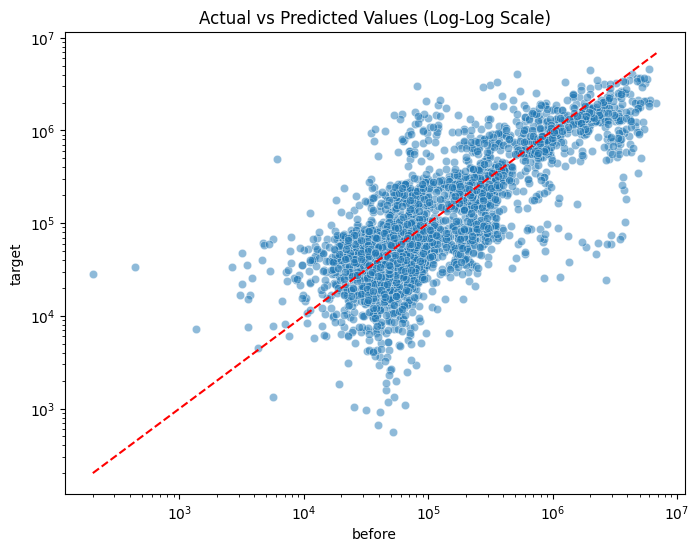

In [50]:

x=train_df["GHG_Direct_Emissions_12_in_metric_tons"]
y=train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]
# 実測値と予測値を対数スケールでプロット
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('before')
plt.ylabel('target')
plt.title('Actual vs Predicted Values (Log-Log Scale)')
plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')  # 45度線
plt.show()

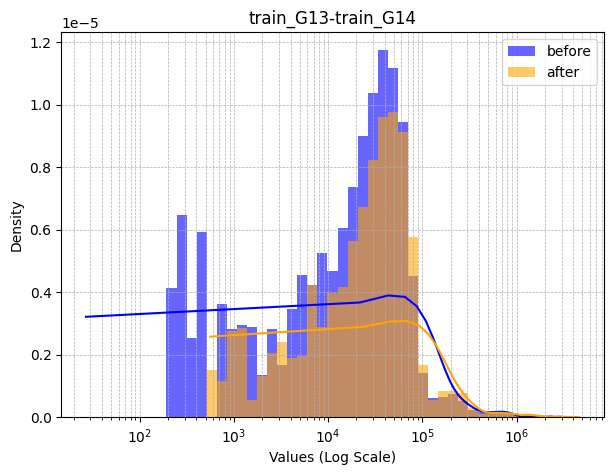

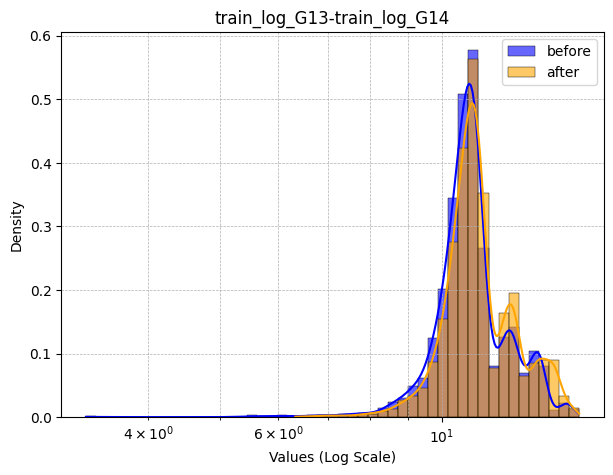

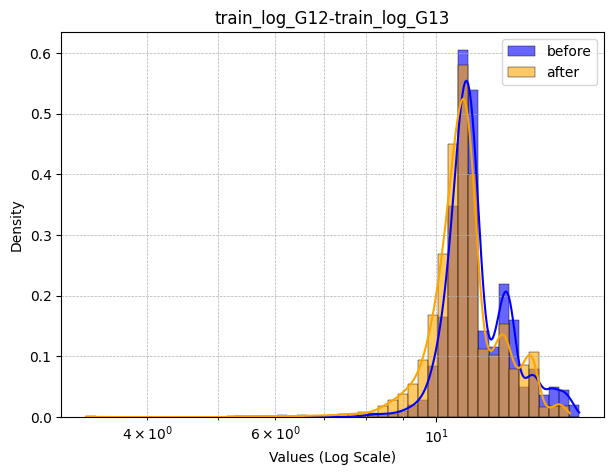

In [51]:

show_plot(train_df["GHG_Direct_Emissions_13_in_metric_tons"],
          train_df["GHG_Direct_Emissions_14_in_metric_tons.1"],
          "train_G13-train_G14")
show_plot(np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]),
          np.log(train_df["GHG_Direct_Emissions_14_in_metric_tons.1"]),
          "train_log_G13-train_log_G14")
show_plot(np.log(train_df["GHG_Direct_Emissions_12_in_metric_tons"]),
          np.log(train_df["GHG_Direct_Emissions_13_in_metric_tons"]),
          "train_log_G12-train_log_G13")


In [52]:
train_all_df = pd.concat([train_df, test_df], axis=0)
train_all_df["GHG_Direct_Emissions_14_in_metric_tons.1"][len(train_df):] = test_df["test_preds"]
print(train_all_df.columns)
train_all_df.drop('test_preds', axis=1, inplace=True)

test_df.drop('test_preds', axis=1, inplace=True)

Index(['TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
       'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs',
       'PrimaryNAICS', 'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons', 'Latitude', 'Longitude',
       'TRI_Air_Emissions_YoY_Change_11', 'TRI_Air_Emissions_YoY_Change_12',
       'TRI_Air_Emissions_YoY_Change_13', 'TRI_Air_Emissions_Growth_Rate_11',
       'TRI_Air_Emissions_Growth_Rate_12', 'TRI_Air_Emissions_Growth_Rate_13',
       'Economic_Sector', 'num_missing', 'oof_predictions',
       'GHG_Direct_Emissions_14_in_metric_tons.1', 'test_preds'],
      dtype='object')


In [53]:
train_all_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,oof_predictions,GHG_Direct_Emissions_14_in_metric_tons.1
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,38681.250000,5.297314e+04
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,64211.078125,5.591007e+04
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,109221.968750,5.567954e+04
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,51154.222656,6.141190e+04
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,52715.906250,4.310047e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,5.497954e+05
2504,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,NaN,1.137684e+05
2505,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,NaN,1.412656e+05
2506,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,NaN,2.599965e+05


In [54]:
# 1. RMSLEの計算（ベクトル化）
# 'test_preds' と 'oof_predictions' を明示的に指定
diff = abs(np.log1p(train_all_df['GHG_Direct_Emissions_14_in_metric_tons.1']) - np.log1p(train_all_df['oof_predictions']))

# 2. 条件を満たす行のマスクを作成
mask = diff > 0.72
# 3. 除外する行の数をカウント
exclude_num = mask.sum()
train_df = train_all_df.copy()
# 4. 条件を満たさない行だけを保持
train_not_mask_df = train_all_df[~mask].reset_index(drop=True)
train_mask_df = train_all_df[mask].reset_index(drop=True)

# 5. 'oof_predictions' 列を削除
train_not_mask_df.drop('oof_predictions', axis=1, inplace=True)
train_mask_df.drop('oof_predictions', axis=1, inplace=True)
train_df.drop('oof_predictions', axis=1, inplace=True)
# 6. 結果の表示
print(f"除外された行数: {exclude_num}")

除外された行数: 1118


In [55]:
train_mask_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,GHG_Direct_Emissions_14_in_metric_tons.1
0,NaN,NaN,NaN,NaN,221,9.803362e+04,49591.258795,5.839936e+04,55458.787269,39.366690,-97.799430,NaN,NaN,NaN,NaN,NaN,NaN,14,1,9.897429e+03
1,NaN,NaN,NaN,NaN,240,4.652013e+04,39261.527827,4.922304e+04,28222.699429,41.037617,-85.208453,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1.026454e+05
2,NaN,NaN,NaN,NaN,80,2.972544e+06,908113.540089,3.375397e+05,329206.449634,33.416151,-81.896431,NaN,NaN,NaN,NaN,NaN,NaN,8,1,1.835038e+06
3,NaN,NaN,NaN,NaN,240,1.197903e+04,37278.738945,5.316759e+04,60125.001392,38.622463,-78.586795,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1.491725e+04
4,78969.043621,176916.939324,85503.349289,103787.620581,95,3.251417e+06,432916.880509,2.980333e+05,601347.581361,41.681417,-83.457722,97947.895703,-91413.590035,18284.271292,1.240333,-0.516703,0.213843,8,0,2.460800e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,105576.256162,23164.809294,100230.914853,10159.691546,136,9.078145e+04,64019.902727,7.269324e+04,122688.279630,32.479516,-100.336139,-82411.446868,77066.105558,-90071.223307,-0.780587,3.326861,-0.898637,8,0,9.156969e+05
1114,NaN,NaN,NaN,NaN,221,5.935361e+04,60224.689105,9.232566e+04,51680.331171,39.891497,-80.449219,NaN,NaN,NaN,NaN,NaN,NaN,14,1,2.475226e+04
1115,NaN,NaN,NaN,NaN,240,3.244078e+05,219036.978753,2.792097e+05,670312.004674,34.538800,-82.311100,NaN,NaN,NaN,NaN,NaN,NaN,1,1,7.252374e+05
1116,NaN,NaN,NaN,NaN,3,5.497884e+04,56463.765036,3.522786e+06,76642.640670,32.523334,-97.102556,NaN,NaN,NaN,NaN,NaN,NaN,9,1,2.451197e+06


'iterations': 254, 'depth': 5, 'learning_rate': 0.08377009991199288, 'l2_leaf_reg': 1, 'bagging_temperature': 0.7204457890870082, 'min_data_in_leaf': 4

In [56]:
from itertools import combinations

def get_models_trained(train, test, target, num_folds, train_eval):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=13)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    train_eval_predictions = np.zeros(len(train_eval))

    # エラーの累計を保持する辞書
    sum_error = {}
    # 各組み合わせの選択回数を保持する辞書
    combination_count = {}

    # 個別モデルの名前リスト
    model_names = ["model1", "model2", "model3", "model4"]

    # 全ての組み合わせを生成（1, 2, 3, 4モデル）
    all_combinations = []
    for r in range(1, 5):
        all_combinations.extend(combinations(model_names, r))

    # 初期化
    for comb in all_combinations:
        sum_error[comb] = 0
        combination_count[comb] = 0

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"Starting Fold {fold + 1}")
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]

        # モデルと損失の初期化
        model_dict = {}
        loss_dict = {}
        valid_pred_dict = {}

        # モデル1: XGBRegressor
        params1 = {
            "n_estimators": 626,
            "max_depth": 3,
            "random_state": 13,
            "min_child_weight": 0.001190123543553736,
            "learning_rate": 0.010519736270936835,
            "subsample": 0.7304788478701394,
            "colsample_bylevel": 0.604447278915981,
            "colsample_bytree": 0.7616852136157319,
            "reg_alpha": 0.115175569924065,
            "reg_lambda": 0.07155347824929895
        }
        model1 = XGBRegressor(**params1)

        # モデル2: CatBoostRegressor
        params                       = {'iterations': 254,
                                        'depth': 5,
                                        'learning_rate': 0.08377009991199288,
                                        'l2_leaf_reg': 1,
                                        'bagging_temperature': 0.7204457890870082,
                                        'min_data_in_leaf': 4,
                                        "random_state":13,
                                         "verbose":0}
        model2                       = CatBoostRegressor(**params)

        # モデル3: XGBRegressor
        params3 ={
            "n_estimators": 897,
            "max_depth": 4,
            "min_child_weight": 1.9636282677053687,
            "learning_rate": 0.006151391207761763,
            "subsample": 0.8251910979922186,
            "colsample_bylevel": 0.6454805596196158,
            "colsample_bytree": 0.598042694363472,
            "reg_alpha": 2.1719824223479005,
            "reg_lambda": 0.009192236594241635,
        }
        model3 = XGBRegressor(**params3)

        # モデル4: CatBoostRegressor
        params4 = {
            "iterations": 940,
            "depth": 3,
            "learning_rate": 0.019908189422344794,
            "l2_leaf_reg": 1,
            "bagging_temperature": 0.5063893392618839,
            "min_data_in_leaf": 1,
            'random_state': 42
        }
        model4 = CatBoostRegressor(**params4, verbose=0)

        # 各モデルの訓練と予測
        models = {
            "model1": model1,
            "model2": model2,
            "model3": model3,
            "model4": model4
        }

        for name, model in models.items():
            model.fit(X_train, np.log1p(y_train))
            preds = np.expm1(model.predict(X_valid))
            rmsle = np.sqrt(mean_squared_log_error(y_valid, preds))
            print(f"Fold {fold + 1} RMSLE for {name} = {rmsle}")
            loss_dict[name] = rmsle
            valid_pred_dict[name] = preds
            sum_error[(name,)] += rmsle

        # すべての2モデルおよび3モデルの組み合わせを評価
        for r in [2, 3]:
            for comb in combinations(model_names, r):
                # 平均予測
                preds_comb = np.mean([valid_pred_dict[model] for model in comb], axis=0)
                rmsle_comb = np.sqrt(mean_squared_log_error(y_valid, preds_comb))
                print(f"Fold {fold + 1} RMSLE for {comb} = {rmsle_comb}")
                loss_dict[comb] = rmsle_comb
                valid_pred_dict[comb] = preds_comb
                sum_error[comb] += rmsle_comb

        # 全モデルのアンサンブル
        preds_all = np.mean([valid_pred_dict[model] for model in model_names], axis=0)
        rmsle_all = np.sqrt(mean_squared_log_error(y_valid, preds_all))
        print(f"Fold {fold + 1} RMSLE for all models ensemble = {rmsle_all}")
        loss_dict[tuple(model_names)] = rmsle_all
        valid_pred_dict[tuple(model_names)] = preds_all
        sum_error[tuple(model_names)] += rmsle_all

        # 最適な組み合わせを選択
        best_combination = min(loss_dict, key=loss_dict.get)
        best_rmsle = loss_dict[best_combination]
        print(f"Fold {fold + 1} best combination: {best_combination} with RMSLE = {best_rmsle}")


        # OOF予測とテスト予測の更新
        if isinstance(best_combination, tuple):
            # 複数モデルのアンサンブル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = np.mean([models[model].predict(test) for model in best_combination], axis=0)
            train_eval_preds = np.mean([models[model].predict(train_eval) for model in best_combination], axis=0)
        else:
            # 単一モデル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = models[best_combination].predict(test)
            train_eval_preds = models[best_combination].predict(train_eval)

        # 各組み合わせの選択回数をインクリメント
        # combination_count[best_combination] += 1

        test_predictions += test_preds / kf.n_splits
        train_eval_predictions += train_eval_preds/ kf.n_splits

        # メモリの解放
        del X_train, X_valid, y_train, y_valid, model1, model2, model3, model4
        gc.collect()

        print('---------------\n')

    # 最終的なOOF RMSLEの計算
    final_RMSLE = np.sqrt(mean_squared_log_error(target, oof_predictions))
    print(f"OOF RMSLE = {final_RMSLE}")

    # テスト予測の逆変換
    final_test_predictions = np.expm1(test_predictions)
    final_train_predictions = np.expm1(train_eval_predictions)

    # 各組み合わせの累積エラーと選択回数を表示
    print("Sum of RMSLE for each combination:")
    for comb, error in sum_error.items():
        print(f"{comb}: {error}")

    # print("\nNumber of times each combination was selected:")
    # for comb, count in combination_count.items():
    #     print(f"{comb}: {count}")

    return oof_predictions, final_test_predictions, final_train_predictions

In [57]:
train_not_mask_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,GHG_Direct_Emissions_14_in_metric_tons.1
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,5.297314e+04
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,5.591007e+04
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,5.567954e+04
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,6.141190e+04
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.310047e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.497954e+05
6041,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.137684e+05
6042,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.412656e+05
6043,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.599965e+05


In [58]:
train_not_mask = train_not_mask_df.iloc[:, :-1].values
train_mask = train_mask_df.iloc[:, :-1].values
train_not_mask_target = train_not_mask_df.iloc[:, -1].values
train_mask_target = train_mask_df.iloc[:, -1].values
test = test_df.values

In [59]:
oof_predictions,test_preds, train_mask_preds = get_models_trained(train_not_mask,test,train_not_mask_target,30, train_mask)

Starting Fold 1
Fold 1 RMSLE for model1 = 0.28509944532711967
Fold 1 RMSLE for model2 = 0.27566678612527795
Fold 1 RMSLE for model3 = 0.2857162806017428
Fold 1 RMSLE for model4 = 0.2833618576524943
Fold 1 RMSLE for ('model1', 'model2') = 0.2781630087474199
Fold 1 RMSLE for ('model1', 'model3') = 0.28490740562267836
Fold 1 RMSLE for ('model1', 'model4') = 0.2828120112709492
Fold 1 RMSLE for ('model2', 'model3') = 0.2784608272140715
Fold 1 RMSLE for ('model2', 'model4') = 0.2782841208609016
Fold 1 RMSLE for ('model3', 'model4') = 0.28274354183852723
Fold 1 RMSLE for ('model1', 'model2', 'model3') = 0.279948237608067
Fold 1 RMSLE for ('model1', 'model2', 'model4') = 0.27923542772413473
Fold 1 RMSLE for ('model1', 'model3', 'model4') = 0.28305973786342986
Fold 1 RMSLE for ('model2', 'model3', 'model4') = 0.27927071693990674
Fold 1 RMSLE for all models ensemble = 0.28012232030104617
Fold 1 best combination: model2 with RMSLE = 0.27566678612527795
---------------

Starting Fold 2
Fold 2 RMSL

In [60]:
train_df = train_df.reset_index(drop=True)
train_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,GHG_Direct_Emissions_14_in_metric_tons.1
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,5.297314e+04
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,5.591007e+04
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,5.567954e+04
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,6.141190e+04
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.310047e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7158,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.497954e+05
7159,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.137684e+05
7160,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.412656e+05
7161,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.599965e+05


In [63]:
# print(type(train_not_mask_df), type(oof_predictions))
# oof_predictions_series = pd.Series(oof_predictions, name='oof_predictions')
# train_not_mask_all_df = pd.concat([train_not_mask_df, oof_predictions], axis=1)
# train_not_mask_all_df.iloc[:, -1]

train_not_mask_df["oof_predictions"] = oof_predictions
train_mask_df["oof_predictions"] = train_mask_preds
train_all_df = pd.concat([train_not_mask_df, train_mask_df], axis=0)
test_df["test_preds"] = test_preds
train_all_df = train_all_df[:len(train_all_df)-exclude_num]
train_all_df.to_csv("train_all_df_092.csv")
test_df.to_csv("test_all_df_092.csv")

In [64]:
train_all_df

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,PrimaryNAICS,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,Latitude,Longitude,TRI_Air_Emissions_YoY_Change_11,TRI_Air_Emissions_YoY_Change_12,TRI_Air_Emissions_YoY_Change_13,TRI_Air_Emissions_Growth_Rate_11,TRI_Air_Emissions_Growth_Rate_12,TRI_Air_Emissions_Growth_Rate_13,Economic_Sector,num_missing,GHG_Direct_Emissions_14_in_metric_tons.1,oof_predictions
0,31566.709644,26644.986107,23410.379903,31809.857564,118,64816.958901,36588.744606,3.790794e+04,45598.125851,40.141389,-87.581111,-4921.723537,-3234.606204,8399.477661,-0.155915,-0.121396,0.358793,8,0,5.297314e+04,4.105144e+04
1,NaN,NaN,NaN,NaN,221,55507.543666,72387.334115,5.822520e+04,76376.547318,38.475305,-81.278957,NaN,NaN,NaN,NaN,NaN,NaN,14,1,5.591007e+04,6.074737e+04
2,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,39.299820,-80.857170,NaN,NaN,NaN,NaN,NaN,NaN,9,1,5.567954e+04,9.984973e+04
3,NaN,NaN,NaN,NaN,21,54811.222708,69339.923002,6.364734e+04,53799.011225,35.490363,-119.042957,NaN,NaN,NaN,NaN,NaN,NaN,15,1,6.141190e+04,5.213393e+04
4,29553.796627,28337.832145,30840.825454,25153.901905,21,81812.306362,53823.561587,7.739116e+04,17662.966241,41.532802,-81.636448,-1215.964481,2502.993309,-5686.923550,-0.041144,0.088327,-0.184396,15,0,4.310047e+04,4.988675e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,NaN,NaN,NaN,NaN,240,110523.066755,98954.793233,3.467008e+06,147802.356027,38.651945,-75.914445,NaN,NaN,NaN,NaN,NaN,NaN,1,1,5.497954e+05,5.765767e+05
6041,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,31.361795,-101.776403,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1.137684e+05,1.001873e+05
6042,22956.125554,23592.402994,25069.498286,24560.172725,132,166520.232511,469732.826538,8.255855e+04,85775.307153,41.005565,-96.154917,636.277440,1477.095292,-509.325561,0.027717,0.062609,-0.020317,8,0,1.412656e+05,1.315022e+05
6043,124460.895022,140816.449347,93118.705227,130326.946431,98,71773.803649,936031.894142,3.369613e+05,156640.371706,39.364417,-93.449361,16355.554326,-47697.744120,37208.241204,0.131411,-0.338723,0.399579,8,0,2.599965e+05,2.677709e+05
